In [1]:
%load_ext blackcellmagic

In [2]:
# -*- coding: utf-8 -*-

from sklearn.linear_model import LogisticRegression
import argparse
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# from azureml.core.run import Run
# from azureml.data.dataset_factory import TabularDatasetFactory


# TODO: Create TabularDataset using TabularDatasetFactory
# Data is located at:
# "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"

In [3]:
df= pd.read_csv("https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df['customerID'].nunique() == df.shape[0]

True

In [6]:
df.drop('customerID', axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:



def clean_data(df):

    # replace blanks with np.nan
    df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
    # convert to float64
    df["TotalCharges"] = df["TotalCharges"].astype("float64")

    # Replace binary values
    df["gender"] = df["gender"].apply(lambda s: 1 if s == "Female" else 0)
    df["Partner"] = df["Partner"].apply(lambda s: 1 if s == "Yes" else 0)
    df["Dependents"] = df["Dependents"].apply(lambda s: 1 if s == "Yes" else 0)
    df["PhoneService"] = df["PhoneService"].apply(lambda s: 1 if s == "Yes" else 0)
    df["PaperlessBilling"] = df["PaperlessBilling"].apply(
        lambda s: 1 if s == "Yes" else 0
    )
    df["Churn"] = df["Churn"].apply(lambda s: 1 if s == "Yes" else 0)

    MultipleLines = pd.get_dummies(df["MultipleLines"], prefix="MultipleLines")
    df.drop("MultipleLines", inplace=True, axis=1)
    df = df.join(MultipleLines)
    InternetService = pd.get_dummies(df["InternetService"], prefix="InternetService")
    df.drop("InternetService", inplace=True, axis=1)
    df = df.join(InternetService)
    OnlineSecurity = pd.get_dummies(df["OnlineSecurity"], prefix="OnlineSecurity")
    df.drop("OnlineSecurity", inplace=True, axis=1)
    df = df.join(OnlineSecurity)
    OnlineBackup = pd.get_dummies(df["OnlineBackup"], prefix="OnlineBackup")
    df.drop("OnlineBackup", inplace=True, axis=1)
    df = df.join(OnlineBackup)
    DeviceProtection = pd.get_dummies(df["DeviceProtection"], prefix="DeviceProtection")
    df.drop("DeviceProtection", inplace=True, axis=1)
    df = df.join(DeviceProtection)
    TechSupport = pd.get_dummies(df["TechSupport"], prefix="TechSupport")
    df.drop("TechSupport", inplace=True, axis=1)
    df = df.join(TechSupport)
    StreamingTV = pd.get_dummies(df["StreamingTV"], prefix="StreamingTV")
    df.drop("StreamingTV", inplace=True, axis=1)
    df = df.join(StreamingTV)
    StreamingMovies = pd.get_dummies(df["StreamingMovies"], prefix="StreamingMovies")
    df.drop("StreamingMovies", inplace=True, axis=1)
    df = df.join(StreamingMovies)
    Contract = pd.get_dummies(df["Contract"], prefix="Contract")
    df.drop("Contract", inplace=True, axis=1)
    df = df.join(Contract)
    PaymentMethod = pd.get_dummies(df["PaymentMethod"], prefix="PaymentMethod")
    df.drop("PaymentMethod", inplace=True, axis=1)
    df = df.join(PaymentMethod)
    y_df = df.pop("Churn")
    # x_df = df.drop("Churn", inplace=True, axis=1)

    return df, y_df


x, y = clean_data(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   int64  
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


In [9]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [23]:
# https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/
# https://towardsdatascience.com/practical-machine-learning-with-scikit-learn-de014bd9d4e5
# example of using the ColumnTransformer for the Abalone dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import accuracy_score, make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [20]:
# load dataset
df = pd.read_csv("https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv")
df.drop('customerID', axis=1, inplace=True)
df.head()

# split into inputs and outputs
last_ix = len(df.columns) - 1

columns = df.columns

X, y = df.drop(columns[last_ix], axis=1), df[columns[last_ix]]
print(X.shape, y.shape)

y = y.apply(lambda s: 1 if s == "Yes" else 0)


# determine categorical and numerical features
numerical_variables = X.select_dtypes(include=["int64", "float64"]).columns

binary_variables = [
    "gender",
    "Partner",
    "Dependents", 
    "PhoneService",
    "PaperlessBilling",
]

categorical_variables = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "DeviceProtection",
    "TechSupport",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

# define the data preparation for the columns
transformer = [
    ("bin_cat", OneHotEncoder(), binary_variables),
    ("multi_cat", OrdinalEncoder(), categorical_variables),
    ("num", MinMaxScaler(), numerical_variables),
    ("imp_num", SimpleImputer(strategy="median"), numerical_variables),
    ("imp_cat", SimpleImputer(strategy="most_frequent"), numerical_variables)
]
col_transform = ColumnTransformer(transformers=transformer)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

x_train_transformed = col_transform.fit(x_train)

feature_selection = SelectKBest(score_func=chi2,k=8)
model = LogisticRegression(penalty='l2', C=1e-3, max_iter=500, solver='newton-cg')

pipeline = Pipeline([
    ('data_preparation', col_transform),
    ('feature_selection', feature_selection),
    ('model', model)
])


from sklearn import set_config
set_config(display='diagram')
pipeline.fit(x_train, y_train)

params = {
    "model__max_iter": [100, 200, 300, 400, 500],
    "model__C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "model__solver": ["newton-cg", "lbfgs", "liblinear"],
}

grid = GridSearchCV(pipeline, params, cv=5, scoring="accuracy")
grid.fit(x_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

(7043, 19) (7043,)


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7944619472624945
{'model__C': 0.001, 'model__max_iter': 100, 'model__solver': 'newton-cg'}


In [27]:

model = RandomForestClassifier()

pipeline = Pipeline(
    [
        ("data_preparation", col_transform),
        ("feature_selection", feature_selection),
        ("model", model),
    ]
)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=100)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

params = {
    "model__n_estimators": n_estimators,
    "model__max_features": max_features,
    "model__max_depth": max_depth,
    "model__min_samples_split": min_samples_split,
    "model__min_samples_leaf": min_samples_leaf,
    "model__bootstrap": bootstrap,
}


grid = RandomizedSearchCV(
    pipeline, params, cv=5, scoring="accuracy", n_iter=200, n_jobs=7, random_state=0
)
grid.fit(x_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

0.7957011888082131
{'model__n_estimators': 509, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 50, 'model__bootstrap': True}


In [36]:
# load dataset
df = pd.read_csv("https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv")
df.drop('customerID', axis=1, inplace=True)
df.head()

# split into inputs and outputs
last_ix = len(df.columns) - 1

columns = df.columns

X, y = df.drop(columns[last_ix], axis=1), df[columns[last_ix]]
print(X.shape, y.shape)

y = y.apply(lambda s: 1 if s == "Yes" else 0)


# determine categorical and numerical features
numerical_variables = X.select_dtypes(include=["int64", "float64"]).columns

binary_variables = [
    "gender",
    "Partner",
    "Dependents", 
    "PhoneService",
    "PaperlessBilling",
]

categorical_variables = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "DeviceProtection",
    "TechSupport",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

# define the data preparation for the columns
transformer = [
    ("bin_cat", OneHotEncoder(), binary_variables),
    ("multi_cat", OrdinalEncoder(), categorical_variables),
    ("num", MinMaxScaler(), numerical_variables),
    ("imp_num", SimpleImputer(strategy="median"), numerical_variables),
    ("imp_cat", SimpleImputer(strategy="most_frequent"), numerical_variables)
]
col_transform = ColumnTransformer(transformers=transformer)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

x_train_transformed = col_transform.fit(x_train)


clf = XGBClassifier(objective='binary:logistic')

pipeline = Pipeline(
    [
        ("data_preparation", col_transform),
        ("feature_selection", feature_selection),
        ("clf", clf),
    ]
)

from sklearn import set_config
set_config(display='diagram')
pipeline.fit(x_train, y_train)

# Define our search space for grid search
params = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
  }
]

# scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

grid = RandomizedSearchCV(
    pipeline, params, cv=5, scoring='accuracy', n_iter=2, random_state=0, n_jobs=7
)
grid.fit(x_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

(7043, 19) (7043,)


XGBoostError: [12:54:03] /tmp/build/80754af9/xgboost-split_1619724447847/work/src/objective/regression_obj.cu:57: Check failed: preds.Size() == info.labels_.Size() (11268 vs. 5634) :  labels are not correctly providedpreds.size=11268, label.size=5634, Loss: binary:logistic
Stack trace:
  [bt] (0) /home/vhcg77/anaconda3/envs/hyperdrive/lib/libxgboost.so(+0x85c1f) [0x7fd92bc78c1f]
  [bt] (1) /home/vhcg77/anaconda3/envs/hyperdrive/lib/libxgboost.so(+0x2431f7) [0x7fd92be361f7]
  [bt] (2) /home/vhcg77/anaconda3/envs/hyperdrive/lib/libxgboost.so(+0x199d57) [0x7fd92bd8cd57]
  [bt] (3) /home/vhcg77/anaconda3/envs/hyperdrive/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7fd92bc7fc18]
  [bt] (4) /home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/lib-dynload/../../libffi.so.7(+0x69dd) [0x7fd97ec399dd]
  [bt] (5) /home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/lib-dynload/../../libffi.so.7(+0x6067) [0x7fd97ec39067]
  [bt] (6) /home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x140f6) [0x7fd97ec530f6]
  [bt] (7) /home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x1073e) [0x7fd97ec4f73e]
  [bt] (8) /home/vhcg77/anaconda3/envs/hyperdrive/bin/python(_PyObject_MakeTpCall+0x37f) [0x55d0ccf969ef]



In [32]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_preparation', 'feature_selection', 'clf', 'data_preparation__n_jobs', 'data_preparation__remainder', 'data_preparation__sparse_threshold', 'data_preparation__transformer_weights', 'data_preparation__transformers', 'data_preparation__verbose', 'data_preparation__bin_cat', 'data_preparation__multi_cat', 'data_preparation__num', 'data_preparation__imp_num', 'data_preparation__imp_cat', 'data_preparation__bin_cat__categories', 'data_preparation__bin_cat__drop', 'data_preparation__bin_cat__dtype', 'data_preparation__bin_cat__handle_unknown', 'data_preparation__bin_cat__sparse', 'data_preparation__multi_cat__categories', 'data_preparation__multi_cat__dtype', 'data_preparation__multi_cat__handle_unknown', 'data_preparation__multi_cat__unknown_value', 'data_preparation__num__clip', 'data_preparation__num__copy', 'data_preparation__num__feature_range', 'data_preparation__imp_num__add_indicator', 'data_preparation__imp_num__copy', 'data_preparation_

In [21]:
# fit model no training data
model = XGBClassifier()
eval_set = [(x_test, y_test)]
model.fit(x_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.19588
[1]	validation_0-error:0.20298
[2]	validation_0-error:0.19517


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-error:0.19517
[4]	validation_0-error:0.19234
[5]	validation_0-error:0.19375
[6]	validation_0-error:0.19234
[7]	validation_0-error:0.19446
[8]	validation_0-error:0.19588
[9]	validation_0-error:0.19943
[10]	validation_0-error:0.19801
[11]	validation_0-error:0.19943
[12]	validation_0-error:0.19730
[13]	validation_0-error:0.19730
[14]	validation_0-error:0.19801
[15]	validation_0-error:0.19517
[16]	validation_0-error:0.19517
[17]	validation_0-error:0.19304
[18]	validation_0-error:0.19446
[19]	validation_0-error:0.19446
[20]	validation_0-error:0.19588
[21]	validation_0-error:0.19517
[22]	validation_0-error:0.19517
[23]	validation_0-error:0.19446
[24]	validation_0-error:0.19446
[25]	validation_0-error:0.19162
[26]	validation_0-error:0.19304
[27]	validation_0-error:0.19588
[28]	validation_0-error:0.19588
[29]	validation_0-error:0.19517
[30]	validation_0-error:0.19588
[31]	validation_0-error:0.19588
[32]	validation_0-error:0.19446
[33]	validation_0-error:0.19517
[34]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[0]	validation_0-error:0.19010	validation_0-logloss:0.57174	validation_1-error:0.19588	validation_1-logloss:0.57446
[1]	validation_0-error:0.18317	validation_0-logloss:0.50304	validation_1-error:0.20298	validation_1-logloss:0.51076


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-error:0.17625	validation_0-logloss:0.45912	validation_1-error:0.19517	validation_1-logloss:0.47184
[3]	validation_0-error:0.17412	validation_0-logloss:0.42974	validation_1-error:0.19517	validation_1-logloss:0.44826
[4]	validation_0-error:0.17128	validation_0-logloss:0.40770	validation_1-error:0.19234	validation_1-logloss:0.43216
[5]	validation_0-error:0.17110	validation_0-logloss:0.39246	validation_1-error:0.19375	validation_1-logloss:0.42265
[6]	validation_0-error:0.16986	validation_0-logloss:0.38033	validation_1-error:0.19234	validation_1-logloss:0.41401
[7]	validation_0-error:0.16720	validation_0-logloss:0.37066	validation_1-error:0.19446	validation_1-logloss:0.40810
[8]	validation_0-error:0.16507	validation_0-logloss:0.36357	validation_1-error:0.19588	validation_1-logloss:0.40616
[9]	validation_0-error:0.16489	validation_0-logloss:0.35761	validation_1-error:0.19943	validation_1-logloss:0.40498
[10]	validation_0-error:0.16170	validation_0-logloss:0.35311	validation_

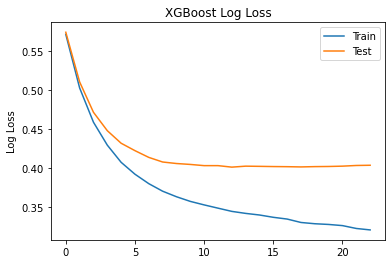

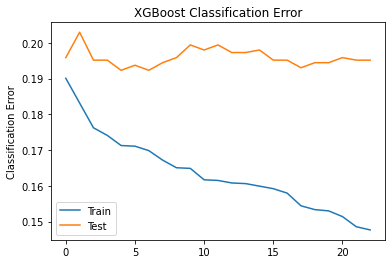

In [27]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data

# fit model no training data
model = XGBClassifier()
eval_set = [(x_train, y_train), (x_test, y_test)]
# model.fit(x_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [28]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.27%


In [57]:
def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (DataFrame): The input data matrix.
        y (Series): The ground truth label.
        
    Returns:
        dict: The best set of parameters found via grid search.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
        
    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)
        fit_params_cv['eval_set'] = [(X_out, y_out)]

        for value_combination in product(*param_values):
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBClassifier(**dict(param_grid_cv))

            xgboost.fit(X_in, y_in, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, X_out, y_out)
            cv_results[param_grid_cv].append(score)
        
    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))
    
    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))
    
    return best_params_xgb

In [58]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold
from collections import defaultdict
from copy import deepcopy
from itertools import product

seed = 0

param_grid = {
    'objective': ['binary:logistic'],
    'n_estimators': [200, 500, 1000, 1500, 2000],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'random_state': [seed]
}

fit_params = {
    'eval_metric': ["error", "logloss", "auc", "aucpr"],
    'early_stopping_rounds': 10,
    'verbose': False
}

scorer = make_scorer(accuracy_score, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, kf, x_train, y_train)

best_xgb = XGBClassifier(**best_params_xgb)
best_xgb.fit(x_train, y_train, eval_metric=fit_params['eval_metric'], verbose=False)
best_score = scorer(best_xgb, x_test, y_test)
print ("The best score for XGBoost on validation set is {:.3f}".format(best_score))

# np.save('best_params_xgb.npy', best_params_xgb)

/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/vhcg77/anaconda3/envs/hyperdrive/lib/pyt

Best score: -0.748
Best Parameters: {'objective': 'binary:logistic', 'n_estimators': 0, 'max_depth': 2, 'learning_rate': 0.001, 'random_state': 0}
The best score for XGBoost on validation set is -0.735


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
dict = {     "apple": "red",     "grape": "purple",     "apple": "red",    "grape": "purple",    "apple": "red",     "grape": "purple",
        
}